# Gradient Boosting Trees

En este tutorial trabajaremos con los modelos basados en Gradiente Boosting Trees. A parte de trabajar con las implementaciones de *sklearn* `HistGradientBoosting`, veremos otras implementaciones de *XGBoost*, y *LightGBM*.

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Preprocesado y modelado
# ==============================================================================
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, KFold
from scipy.stats import randint as sp_randint
from sklearn.model_selection import train_test_split
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
def rmse(y_test, y_test_pred):
  """ Este es mi cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

Utilizaremos el dataset de Housing de California

In [3]:
housing = fetch_california_housing()

X = housing.data
y = housing.target

In [4]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [5]:
# Holdout para la evaluación del modelo. 33% de los datos disponibles para test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)

In [6]:
# Para dibujar las predicciones y los valores reales
def pintaResultados (reg, n):
  plt.subplots(figsize=(30, 5))
  x = np.arange(y_test[:n].size)
  pred = reg.predict(X=X_test)
  plt.plot(x, y_test[:n], 'b.', label='Verdaderas')
  plt.plot(x, pred[:n], 'g^', label='Predichas')
  plt.legend();

# HistGradientBoostingRegressor
Los parámetros más importantes de la implantación de sklearn (`HistGradientBoostingRegressor`) para controlar el crecimiento de los árboles, la velocidad de aprendizaje del modelo, y los que gestionan la parada temprana para evitar *overfitting*, son:

- `learning_rate`: reduce la contribución de cada árbol multiplicando su influencia original por este valor.
- `max_iter`: El número máximo de iteraciones del proceso de boosting, es decir, el número máximo de árboles.
- `max_depth`: profundidad máxima que pueden alcanzar los árboles.
- `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.
- `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.
- `validation_fraction`: proporción de datos separados del conjunto entrenamiento y empleados como conjunto de validación para determinar la parada temprana (*early stopping*).
- `n_iter_no_change`: número de iteraciones consecutivas en las que no se debe superar el tol para que el algoritmo se detenga (*early stopping*). Si su valor es None se desactiva la parada temprana.
- `tol`: porcentaje mínimo de mejora entre dos iteraciones consecutivas por debajo del cual se considera que el modelo no ha mejorado.


RMSE de GB: 0.46742169461410954


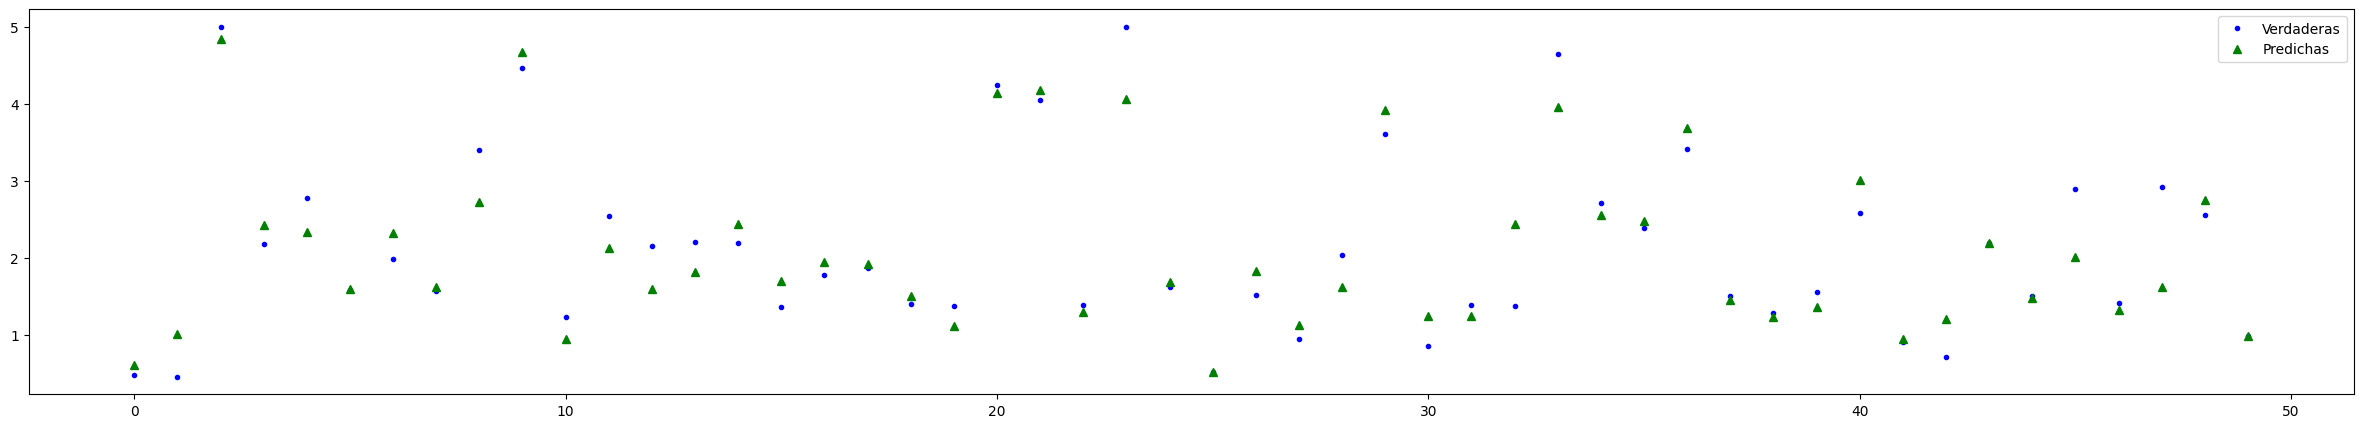

In [7]:
# Creación del modelo
# ==============================================================================
regr_gb = HistGradientBoostingRegressor(
            random_state = 42
         )

# Entrenamiento del modelo
# ==============================================================================
np.random.seed(42)
regr_gb.fit(X_train, y_train)
print(f"RMSE de GB: {rmse(y_test, regr_gb.predict(X=X_test))}")
pintaResultados(regr_gb,50)

## Búsqueda de parámetros con Random Search
Vamos a realizar una búsqueda usando Random Search

In [8]:
param_grid = {'max_depth'         : [None, 1, 3, 5, 10, 20, 30],
              'learning_rate'     : [0.001, 0.01, 0.1, 0.2],
              'l2_regularization' : [0, 1],
              'max_leaf_nodes': [3, 10, 30, 40]
             }

inner = KFold(n_splits=3, shuffle=True, random_state=42)

budget = 100
# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
regr = RandomizedSearchCV (estimator  = HistGradientBoostingRegressor(max_iter            = 1000,
                                                                      random_state        = 42,
                                                                      # Activación de la parada temprana
                                                                      validation_fraction = 0.1,
                                                                      n_iter_no_change    = 5,
                                                                      tol                 = 0.0001),
                           param_distributions = param_grid,
                           scoring='neg_mean_squared_error',
                           cv=inner,
                           refit=True,
                           n_jobs=-1,
                           verbose=1,
                           n_iter=budget,
                           return_train_score=True)

np.random.seed(42)
regr.fit(X=X_train, y=y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=HistGradientBoostingRegressor(max_iter=1000,
                                                           n_iter_no_change=5,
                                                           random_state=42,
                                                           tol=0.0001),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'l2_regularization': [0, 1],
                                        'learning_rate': [0.001, 0.01, 0.1,
                                                          0.2],
                                        'max_depth': [None, 1, 3, 5, 10, 20,
                                                      30],
                                        'max_leaf_nodes': [3, 10, 30, 40]},
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=1)

In [9]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(regr.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_leaf_nodes,param_max_depth,param_learning_rate,param_l2_regularization,mean_test_score,std_test_score,mean_train_score,std_train_score
97,10,20,0.1,0,-0.220553,0.009266,-0.079358,0.002008
47,10,10,0.1,0,-0.220553,0.009266,-0.079358,0.002008
62,10,5,0.1,1,-0.221882,0.009894,-0.087470,0.002040
31,10,5,0.1,0,-0.222255,0.010785,-0.086647,0.002386


RMSE de GB con búsqueda de hiperparámetros: 0.4848998185009243


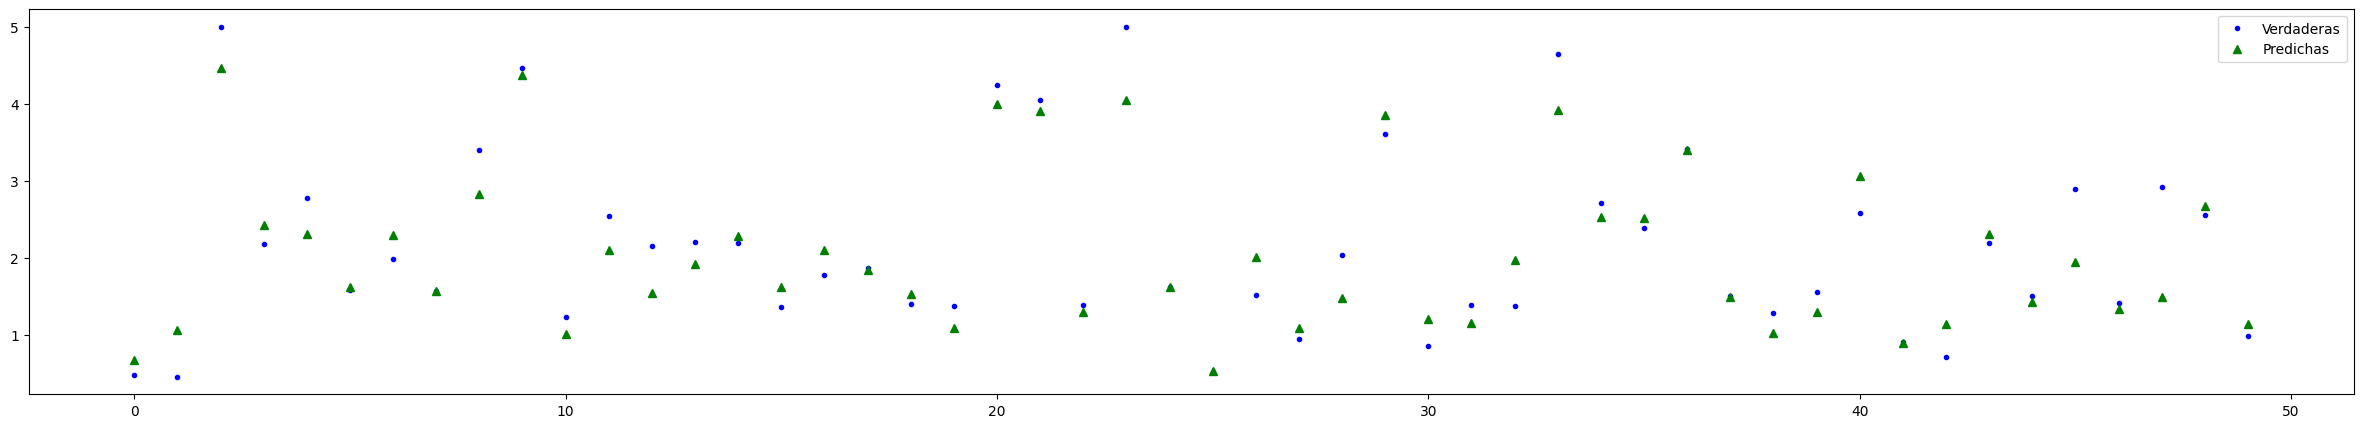

In [10]:
# Esto sería una estimación del accuracy usando Holdout
print(f"RMSE de GB con búsqueda de hiperparámetros: {rmse(y_test, regr.predict(X=X_test))}")
pintaResultados(regr,50)

In [11]:
regr.best_params_, -regr.best_score_

({'max_leaf_nodes': 10,
  'max_depth': 10,
  'learning_rate': 0.1,
  'l2_regularization': 0},
 0.22055337448819023)

Al poner el parámetro `refit=True` se reentrena el modelo indicando los valores óptimos en sus argumentos. Este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.

In [12]:
modelo_final = regr.best_estimator_
# Entrenamos con todos los datos para el modelo final
_ = modelo_final.fit(X,y)

## Importancia por permutación
Identifica la influencia que tiene cada predictor sobre una determinada métrica de evaluación del modelo 

In [13]:
from sklearn.inspection import permutation_importance
import multiprocessing

importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 42
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )

df_importancia['feature'] = housing.feature_names
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
6,0.812941,0.005373,Latitude
7,0.716713,0.005382,Longitude
0,0.498654,0.002315,MedInc
5,0.192914,0.003651,AveOccup
2,0.068653,0.000907,AveRooms
1,0.053602,0.002712,HouseAge
3,0.015299,0.000669,AveBedrms
4,0.014792,0.000517,Population


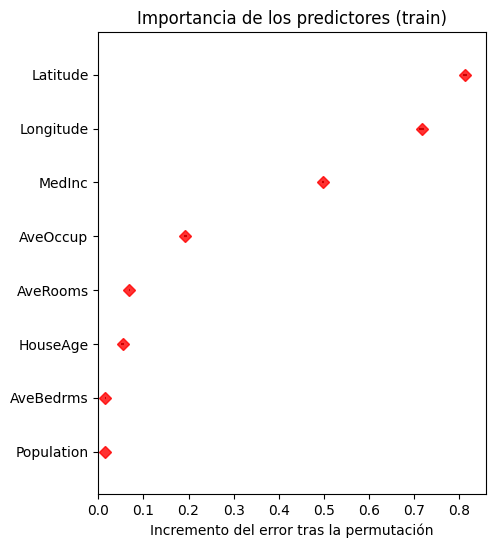

In [14]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

# XGBoost
Existe un API que recubre la librería original para que tenga parámetros y métodos similares a Scikit-Learn. Los parámetros más relevantes son:

- `n_estimators` (int) – Número de árboles usados. Equivalente al número de rondas de boosting.
- `max_depth` (Optional[int]) – Máxima profundidad de los árboles.
- `subsample` (Optional[0-1]) - Proporción de submuestreo de las instancias de entrenamiento. Si se establece en 0.5, XGBoost muestreará aleatoriamente la mitad de los datos de entrenamiento antes de hacer crecer los árboles, lo que evitará el sobreajuste. El submuestreo se realizará una vez en cada iteración de boosting.
- `learning_rate` (Optional[float]) – Indice de aprendizaje en el Boosting  (xgb’s “eta”). Es un valor de regularización/penalización para evitar sobreajuste, limitando la influencia de cada modelo en el conjunto del ensemble
- `booster` (Optional[str]) – Especifica el modelo a utilizar: gbtree, gblinear or dart.
- `gamma` (Optional[float]) – (min_split_loss) Reducción mínima del error necesario para realizar otra partición en un nodo hoja del árbol.
- `grow_policy` – Política de crecimiento del árbol. 0: favorece la división en los nodos más cercanos al nodo, es decir, crece en profundidad. 1: favorece la división en los nodos con mayor cambio del error.


In [15]:
#!pip install xgboost

In [17]:
# Instalación XGBoost: !pip install xgboost
from xgboost import XGBRegressor

In [18]:
# espacio de búsqueda
param_grid = {'max_depth'        : [None, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
              'n_estimators'     : sp_randint(50, 500)
              }

# Búsqueda por random search con validación cruzada
# ==============================================================================
inner = KFold(n_splits=3, shuffle=True, random_state=42)
budget = 100
grid = RandomizedSearchCV(
    estimator  = XGBRegressor(random_state = 42),
    param_distributions= param_grid,
    scoring    = 'neg_root_mean_squared_error',
    n_jobs     = multiprocessing.cpu_count() - 1,
    cv         = inner,
    refit      = True,
    verbose    = 0,
    n_iter=budget
)

grid.fit(X = X_train, y = y_train)



RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=100, n_jobs=15,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.4, 0.5, 0.6, 0.7,
                                                          0.8, 0.9, 1],
                                        'max_depth': [None, 1, 3, 5, 10, 20],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FEA4A2D1C0>,
                                        'subsample': [0.5, 1]},
                   scoring='neg_root_mean_squared_error')

In [19]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score
22,0.05,5,492,0.5,-0.477010,0.009892
9,0.1,None,353,1,-0.480525,0.011811
12,0.2,3,453,1,-0.480966,0.010018
35,0.1,None,272,1,-0.481668,0.012342


RMSE de XGB con búsqueda de hiperparámetros: 0.4611661136384918


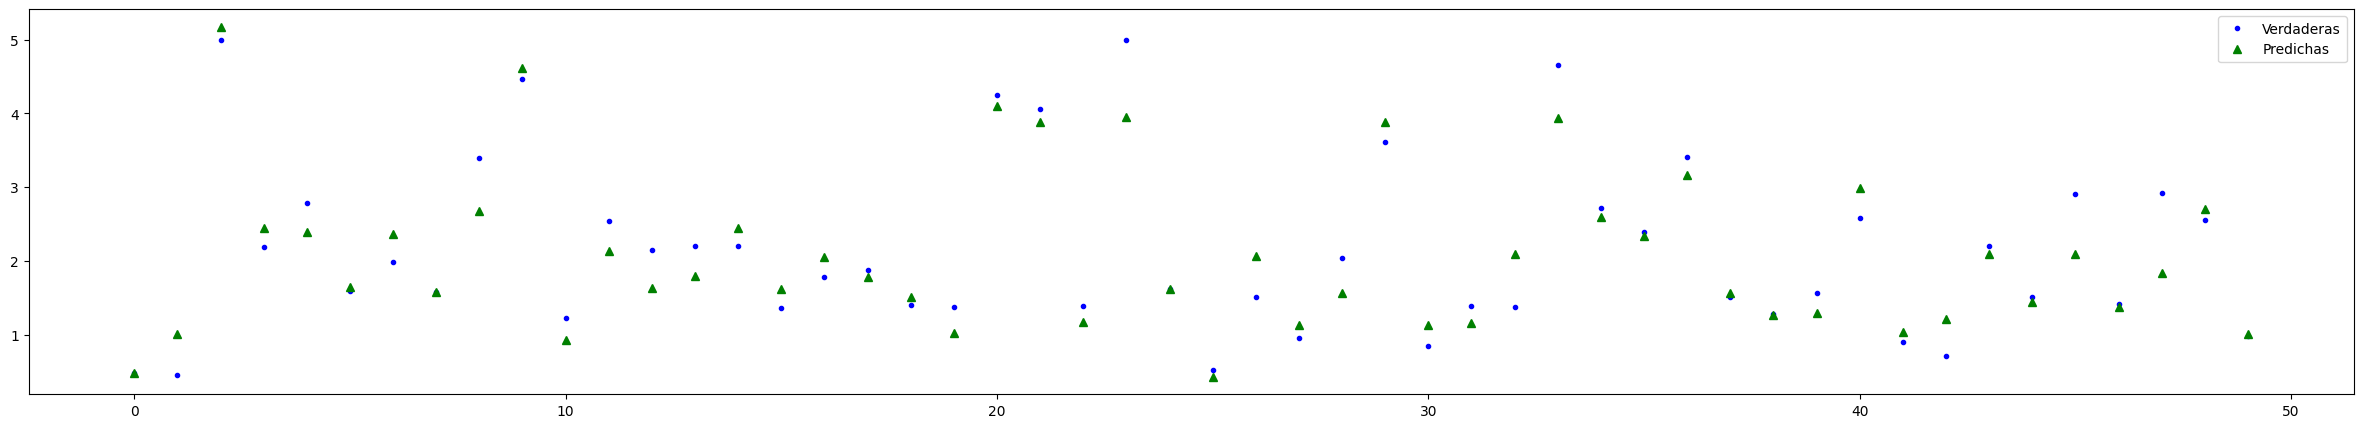

In [20]:
# Esto sería una estimación del error usando Holdout
print(f"RMSE de XGB con búsqueda de hiperparámetros: {rmse(y_test, grid.predict(X=X_test))}")
pintaResultados(grid,50)

In [21]:
grid.best_params_, -grid.best_score_

({'learning_rate': 0.05,
  'max_depth': 5,
  'n_estimators': 492,
  'subsample': 0.5},
 0.47700958288651735)

Al poner el parámetro `refit=True` se reentrena el modelo indicando los valores óptimos en sus argumentos. Este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.

In [22]:
modelo_final = grid.best_estimator_
# Entrenamos con todos los datos para el modelo final
_ = modelo_final.fit(X,y)

# LightGBM
Se trata de un algoritmo de Boosting con rendimientos similares a XGBoost de forma más rápida. Parámetros más relevantes:
- `n_estimators` (int) – Número de árboles usados. Equivalente al número de rondas de boosting.
- `max_depth` (Optional[int]) – Máxima profundidad de los árboles. (<=0 indica que no hay límite)
- `subsample` (Optional[0-1]) - (o bagging_fraction) para especificar el porcentaje de muestras utilizadas por iteración de construcción del árbol. Esto significa que algunas filas se seleccionarán aleatoriamente para ajustar cada árbol. Esto mejora la generalización y  la velocidad de entrenamiento.
- `learning_rate` (Optional[float]) – Indice de aprendizaje en el Boosting. Es un valor de regularización/penalización para evitar sobreajuste, limitando la influencia de cada modelo en el conjunto del ensemble


In [23]:
#!pip install lightgbm
#!conda install -c conda-forge lightgbm

In [25]:
from lightgbm import LGBMRegressor

In [26]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators'     : sp_randint(100, 5000),
              'max_depth'        : [-1, 1, 3, 5, 10, 20],
              'subsample'        : [0.5, 1],
              'learning_rate'    : [0.001, 0.01, 0.1],
              'boosting_type'    : ['gbdt']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
inner = KFold(n_splits=3, shuffle=True, random_state=42)
budget = 75
grid = RandomizedSearchCV(
        estimator  = LGBMRegressor(random_state=42),
        param_distributions = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = inner, 
        refit      = True,
        verbose    = 0,
        return_train_score = True,
        n_iter=budget
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 13828, number of used features: 8
[LightGBM] [Info] Start training from score 2.066636


,param_boosting_type,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,mean_test_score,std_test_score,mean_train_score,std_train_score
37,gbdt,0.01,-1,2293,1,-0.470166,0.009636,-0.290782,0.002360
65,gbdt,0.1,10,771,1,-0.470540,0.009168,-0.157362,0.001361
70,gbdt,0.01,10,2396,0.5,-0.470674,0.011654,-0.291114,0.003006
41,gbdt,0.1,-1,504,1,-0.471308,0.009679,-0.202773,0.002195


RMSE de LightGBM con búsqueda de hiperparámetros: 0.4479561615712746


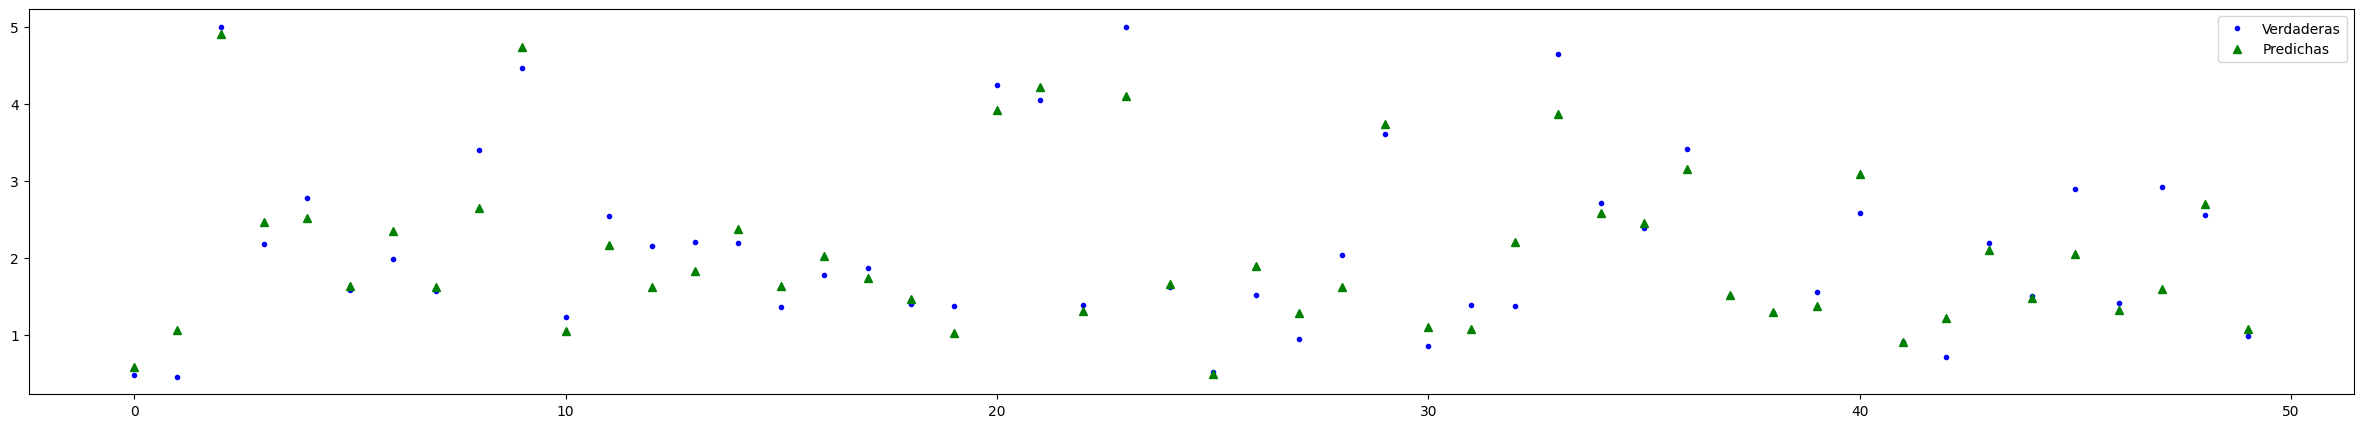

In [27]:
# Esto sería una estimación del error usando Holdout
print(f"RMSE de LightGBM con búsqueda de hiperparámetros: {rmse(y_test, grid.predict(X=X_test))}")
pintaResultados(grid,50)

In [28]:
grid.best_params_, -grid.best_score_

({'boosting_type': 'gbdt',
  'learning_rate': 0.01,
  'max_depth': -1,
  'n_estimators': 2293,
  'subsample': 1},
 0.4701663958781477)

In [29]:
modelo_final = grid.best_estimator_
# Entrenamos con todos los datos para el modelo final
_ = modelo_final.fit(X,y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 20640, number of used features: 8
[LightGBM] [Info] Start training from score 2.068558
